<a href="https://colab.research.google.com/github/SalFierro83/SalFierro83/blob/main/Gym_Churn_Project_Dec25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# churn_project.py
# Run:  pip install xgboost scikit-learn pandas matplotlib numpy
# Then: python churn_project.py

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.impute import SimpleImputer

# Try XGBoost; fallback to sklearn HistGradientBoosting if not present
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    USE_XGB = False

# ---------- 1) MAKE A REALISTIC SYNTHETIC TELECOM DATASET ----------
rng = np.random.default_rng(42)
n = 5000  # change as you like

contract   = rng.choice(["month-to-month","6-months","one-year"], size=n, p=[0.62,0.23,0.15])
internet   = rng.choice(["dsl","fiber","none"], size=n, p=[0.35,0.50,0.15])
payment    = rng.choice(["electronic","credit_card","bank_transfer","mailed_check"], size=n, p=[0.45,0.25,0.20,0.10])
partner    = rng.choice(["yes","no"], size=n, p=[0.46,0.54])
dependents = rng.choice(["yes","no"], size=n, p=[0.32,0.68])
paperless  = rng.choice(["yes","no"], size=n, p=[0.70,0.30])

tenure = rng.integers(0, 72, size=n)
monthly = rng.normal(70, 30, size=n).clip(15,150)
total   = monthly * (tenure + rng.normal(0,3,size=n)).clip(0,None)

# latent risk → churn probability
risk = (
    0.9*(contract=="month-to-month").astype(float)
  + 0.5*(internet=="fiber").astype(float)
  + 0.4*(paperless=="yes").astype(float)
  + 0.3*(payment=="electronic").astype(float)
  - 0.6*(tenure/72)
  + 0.002*(monthly-70)
  + rng.normal(0,0.4,size=n)
)
p = 1/(1+np.exp(-risk))
churn = (rng.uniform(0,1,size=n) < p*0.6).astype(int)  # ~30% churn

df = pd.DataFrame({
    "contract":contract,"internet":internet,"payment":payment,
    "partner":partner,"dependents":dependents,"paperless":paperless,
    "tenure":tenure,"monthly_charges":monthly.round(2),"total_charges":total.round(2),
    "churn":churn
})

# sprinkle a few missings like real life
for col in ["internet","payment","monthly_charges"]:
    mask = rng.choice([True,False], size=n, p=[0.02,0.98])
    df.loc[mask,col] = np.nan

# ---------- 2) SPLIT ----------
X = df.drop(columns=["churn"])
y = df["churn"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

# ---------- 3) PREPROCESS ----------
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
prep = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

# ---------- 4) MODEL ----------
if USE_XGB:
    model = XGBClassifier(
        n_estimators=250, learning_rate=0.08, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        eval_metric="logloss", tree_method="hist", random_state=123
    )
else:
    model = HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.08, max_iter=250, random_state=123
    )

pipe = Pipeline([("prep", prep), ("model", model)])
pipe.fit(X_tr, y_tr)

# ---------- 5) EVALUATE ----------
if hasattr(model, "predict_proba"):
    y_proba = pipe.predict_proba(X_te)[:,1]
else:  # decision_function fallback
    s = pipe.decision_function(X_te)
    y_proba = 1/(1+np.exp(-s))

y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_te, y_proba)
acc = accuracy_score(y_te, y_pred)
cm  = confusion_matrix(y_te, y_pred)

print(f"ROC-AUC:  {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)

# ---------- 6) PLOTS ----------
RocCurveDisplay.from_predictions(y_te, y_proba)
plt.title("ROC Curve - Churn")
plt.show()

# simple confusion matrix plot
import numpy as np
import matplotlib.pyplot as plt

    def plot_confusion_matrix(cm, ax=None, class_names=["No Churn", "Churn"]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    # Percentages
    cm_percent = cm / cm.sum() * 100

    # Adaptive text color
    vmin, vmax = im.get_clim()
    threshold = (vmin + vmax) / 2

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            pct = cm_percent[i, j]
            color = "white" if im.get_array()[i, j] > threshold else "black"
            ax.text(j, i, f"{value}\n({pct:.1f}%)",
                    ha="center", va="center",
                    color=color, fontsize=12, fontweight="bold")

    return ax

    # Use a good colormap
    im = ax.imshow(cm, cmap="Blues")

    # Title + ticks
    ax.set_title("Confusion Matrix", fontsize=16, pad=15)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=12)
    ax.set_yticklabels(class_names, fontsize=12)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)

    # Calculate percentages
    cm_percent = cm / cm.sum() * 100

    # Adaptive text colors
    vmin, vmax = im.get_clim()
    threshold = (vmin + vmax) / 2

    # Write text inside each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            percent = cm_percent[i, j]

            text_color = "white" if im.get_array()[i, j] > threshold else "black"

            ax.text(
                j, i,
                f"{value}\n({percent:.1f}%)",
                ha="center", va="center",
                color=text_color,
                fontsize=12,
            )

    # Add grid lines
    ax.set_xticks(np.arange(len(class_names)+1)-0.5, minor=True)
    ax.set_yticks(np.arange(len(class_names)+1)-0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()
    plt.show()

# ---- Call the function ----
plot_confusion_matrix(cm)

# ---------- 7) FEATURE IMPORTANCE ----------
ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols

if USE_XGB:
    importances = pipe.named_steps["model"].feature_importances_
else:
    importances = pipe.named_steps["model"].feature_importances_

fi = pd.DataFrame({"feature":feature_names, "importance":importances})\
       .sort_values("importance", ascending=False).head(15)
print("\nTop features:\n", fi)

fi.plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top Feature Importances")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
axes[0].set_title("ROC Curve", fontsize=14)

# RIGHT: Confusion matrix
plot_confusion_matrix(cm, ax=axes[1], class_names=["No Churn", "Churn"])
axes[1].set_title("Confusion Matrix", fontsize=14)

plt.tight_layout()
plt.show()

# ---------- 8) SAVE ARTIFACTS ----------
df.to_csv("churn_dataset.csv", index=False)
pd.DataFrame({"Metric":["ROC-AUC","Accuracy"],"Value":[auc,acc]}).to_csv("churn_metrics.csv", index=False)
fi.to_csv("churn_top_features.csv", index=False)
print("\nSaved: churn_dataset.csv, churn_metrics.csv, churn_top_features.csv")

IndentationError: unexpected indent (ipython-input-3022793117.py, line 124)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.impute import SimpleImputer

# Try XGBoost -----------------------------------------------------------------
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    USE_XGB = False


# -----------------------------------------------------------------------------
# 1. SYNTHETIC CHURN DATASET
# -----------------------------------------------------------------------------
rng = np.random.default_rng(42)
n = 5000

contract   = rng.choice(["month-to-month","one-year","two-year"], size=n, p=[0.62,0.23,0.15])
internet   = rng.choice(["dsl","fiber","none"], size=n, p=[0.35,0.50,0.15])
payment    = rng.choice(["electronic","credit_card","bank_transfer","mailed_check"], size=n, p=[0.45,0.25,0.20,0.10])
partner    = rng.choice(["yes","no"], size=n, p=[0.46,0.54])
dependents = rng.choice(["yes","no"], size=n, p=[0.32,0.68])
paperless  = rng.choice(["yes","no"], size=n, p=[0.70,0.30])

tenure = rng.integers(0, 72, size=n)
monthly_charges = rng.normal(70, 30, size=n).clip(15,150)
total_charges = monthly_charges * (tenure + rng.normal(0,3,size=n)).clip(0,None)

# latent churn risk
risk = (
    0.9*(contract=="month-to-month").astype(float) +
    0.5*(internet=="fiber").astype(float) +
    0.4*(paperless=="yes").astype(float) +
    0.3*(payment=="electronic").astype(float) -
    0.6*(tenure/72) +
    0.002*(monthly_charges-70) +
    rng.normal(0,0.4,size=n)
)

prob_churn = 1/(1+np.exp(-risk))
churn = (rng.uniform(0,1,size=n) < prob_churn*0.6).astype(int)

df = pd.DataFrame({
    "contract":contract,"internet":internet,"payment":payment,
    "partner":partner,"dependents":dependents,"paperless":paperless,
    "tenure":tenure,"monthly_charges":monthly_charges.round(2),
    "total_charges":total_charges.round(2),
    "churn":churn
})

# add a few missing values
for col in ["internet","payment","monthly_charges"]:
    mask = rng.choice([True,False], size=n, p=[0.02,0.98])
    df.loc[mask, col] = np.nan


# -----------------------------------------------------------------------------
# 2. TRAIN/TEST SPLIT
# -----------------------------------------------------------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)


# -----------------------------------------------------------------------------
# 3. PREPROCESSING PIPELINE
# -----------------------------------------------------------------------------
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])


# -----------------------------------------------------------------------------
# 4. MODEL
# -----------------------------------------------------------------------------
if USE_XGB:
    model = XGBClassifier(
        n_estimators=250,
        learning_rate=0.08,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        tree_method="hist",
        random_state=123
    )
else:
    model = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.08,
        max_iter=250,
        random_state=123
    )

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])


# -----------------------------------------------------------------------------
# 5. TRAIN THE MODEL
# -----------------------------------------------------------------------------
pipe.fit(X_train, y_train)


# -----------------------------------------------------------------------------
# 6. PREDICT + METRICS
# -----------------------------------------------------------------------------
# Probability output
if hasattr(pipe.named_steps["model"], "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:,1]
else:
    s = pipe.decision_function(X_test)
    y_proba = 1/(1+np.exp(-s))

y_pred = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)

print("ROC-AUC:", auc)
print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)


# -----------------------------------------------------------------------------
# 7. BEAUTIFUL CONFUSION MATRIX FUNCTION
# -----------------------------------------------------------------------------
def plot_confusion_matrix(cm, ax=None, class_names=["No Churn", "Churn"]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    ax.set_title("Confusion Matrix")

    # Percentages
    cm_percent = cm / cm.sum() * 100

    # Adaptive text color
    vmin, vmax = im.get_clim()
    threshold = (vmin + vmax) / 2

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            pct = cm_percent[i, j]
            color = "white" if im.get_array()[i, j] > threshold else "black"
            ax.text(j, i, f"{value}\n({pct:.1f}%)",
                    ha="center", va="center",
                    color=color, fontsize=12, fontweight="bold")

    return ax


# -----------------------------------------------------------------------------
# 8. SIDE-BY-SIDE PLOTS (ROC + CONFUSION MATRIX)
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
axes[0].set_title("ROC Curve", fontsize=14)

# Confusion Matrix
plot_confusion_matrix(cm, ax=axes[1], class_names=["No Churn", "Churn"])
axes[1].set_title("Confusion Matrix", fontsize=14)

plt.tight_layout()
plt.show()

SyntaxError: unmatched ')' (ipython-input-1845067055.py, line 164)

ROC-AUC: 0.5423452252708953
Accuracy: 0.5712
Confusion Matrix:
 [[548 186]
 [350 166]]


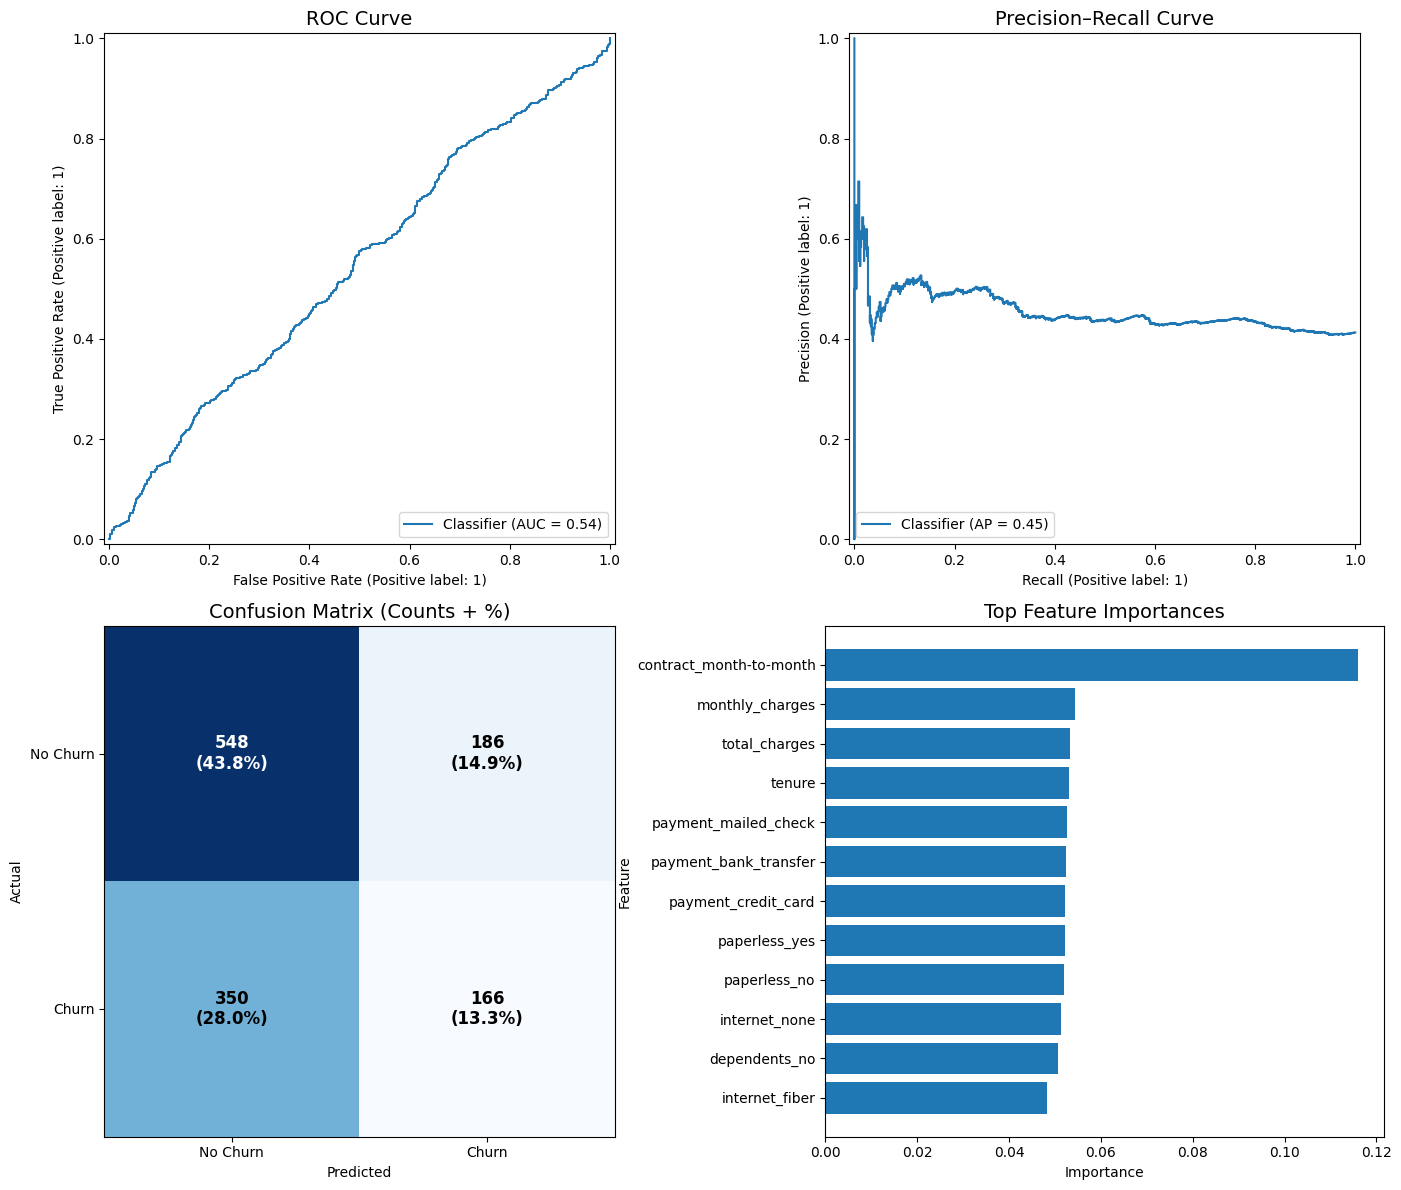

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.impute import SimpleImputer

# Try XGBoost -----------------------------------------------------------------
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    USE_XGB = False


# -----------------------------------------------------------------------------
# 1. SYNTHETIC CHURN DATASET
# -----------------------------------------------------------------------------
rng = np.random.default_rng(42)
n = 5000

contract   = rng.choice(["month-to-month","one-year","two-year"], size=n, p=[0.62,0.23,0.15])
internet   = rng.choice(["dsl","fiber","none"], size=n, p=[0.35,0.50,0.15])
payment    = rng.choice(["electronic","credit_card","bank_transfer","mailed_check"], size=n, p=[0.45,0.25,0.20,0.10])
partner    = rng.choice(["yes","no"], size=n, p=[0.46,0.54])
dependents = rng.choice(["yes","no"], size=n, p=[0.32,0.68])
paperless  = rng.choice(["yes","no"], size=n, p=[0.70,0.30])

tenure = rng.integers(0, 72, size=n)
monthly_charges = rng.normal(70, 30, size=n).clip(15,150)
total_charges = monthly_charges * (tenure + rng.normal(0,3,size=n)).clip(0,None)

# latent churn risk
risk = (
    0.9*(contract=="month-to-month").astype(float) +
    0.5*(internet=="fiber").astype(float) +
    0.4*(paperless=="yes").astype(float) +
    0.3*(payment=="electronic").astype(float) -
    0.6*(tenure/72) +
    0.002*(monthly_charges-70) +
    rng.normal(0,0.4,size=n)
)

prob_churn = 1/(1+np.exp(-risk))
churn = (rng.uniform(0,1,size=n) < prob_churn*0.6).astype(int)

df = pd.DataFrame({
    "contract":contract,"internet":internet,"payment":payment,
    "partner":partner,"dependents":dependents,"paperless":paperless,
    "tenure":tenure,"monthly_charges":monthly_charges.round(2),
    "total_charges":total_charges.round(2),
    "churn":churn
})

# add a few missing values
for col in ["internet","payment","monthly_charges"]:
    mask = rng.choice([True,False], size=n, p=[0.02,0.98])
    df.loc[mask, col] = np.nan


# -----------------------------------------------------------------------------
# 2. TRAIN/TEST SPLIT
# -----------------------------------------------------------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)


# -----------------------------------------------------------------------------
# 3. PREPROCESSING PIPELINE
# -----------------------------------------------------------------------------
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])


# -----------------------------------------------------------------------------
# 4. MODEL
# -----------------------------------------------------------------------------
if USE_XGB:
    model = XGBClassifier(
        n_estimators=250,
        learning_rate=0.08,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        tree_method="hist",
        random_state=123
    )
else:
    model = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.08,
        max_iter=250,
        random_state=123
    )

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])


# -----------------------------------------------------------------------------
# 5. TRAIN THE MODEL
# -----------------------------------------------------------------------------
pipe.fit(X_train, y_train)


# -----------------------------------------------------------------------------
# 6. PREDICT + METRICS
# -----------------------------------------------------------------------------
# Probability output
if hasattr(pipe.named_steps["model"], "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:,1]
else:
    s = pipe.decision_function(X_test)
    y_proba = 1/(1+np.exp(-s))

y_pred = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)

print("ROC-AUC:", auc)
print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)


# -----------------------------------------------------------------------------
# 7. BEAUTIFUL CONFUSION MATRIX FUNCTION
# -----------------------------------------------------------------------------
def plot_confusion_matrix(cm, ax=None, class_names=["No Churn", "Churn"]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    cm_percent = cm / cm.sum() * 100

    vmin, vmax = im.get_clim()
    threshold = (vmin + vmax) / 2

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            pct = cm_percent[i, j]
            color = "white" if im.get_array()[i, j] > threshold else "black"
            ax.text(
                j, i,
                f"{value}\n({pct:.1f}%)",
                ha="center", va="center",
                color=color, fontsize=12, fontweight="bold"
            )

    return ax


# -----------------------------------------------------------------------------
# 8. SIDE-BY-SIDE PLOTS (ROC + CONFUSION MATRIX)
# -----------------------------------------------------------------------------
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import PrecisionRecallDisplay
# -------------------------------------------
# FEATURE IMPORTANCE FUNCTION  (ADD THIS ABOVE)
# -------------------------------------------
def get_feature_importances(pipe, cat_cols, num_cols):
    # Extract names after preprocessing
    ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names = ohe_names + num_cols

    # Extract importances
    model = pipe.named_steps["model"]
    importances = model.feature_importances_

    df_fi = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
    )
    return df_fi

# Get feature importances
fi = get_feature_importances(pipe, cat_cols, num_cols)
top_fi = fi.head(12)   # show top 12 features only

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1️⃣ ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0,0])
axes[0,0].set_title("ROC Curve", fontsize=14)

# 2️⃣ Precision–Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[0,1])
axes[0,1].set_title("Precision–Recall Curve", fontsize=14)

# 3️⃣ Confusion Matrix
plot_confusion_matrix(cm, ax=axes[1,0], class_names=["No Churn", "Churn"])
axes[1,0].set_title("Confusion Matrix (Counts + %)", fontsize=14)

# 4️⃣ FEATURE IMPORTANCE BAR CHART
axes[1,1].barh(top_fi["feature"][::-1], top_fi["importance"][::-1])
axes[1,1].set_title("Top Feature Importances", fontsize=14)
axes[1,1].set_xlabel("Importance")
axes[1,1].set_ylabel("Feature")
axes[1,1].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

ROC-AUC: 0.558 | Accuracy: 0.602

Classification report (0.5 threshold):

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1738
           1       0.35      0.36      0.36       762

    accuracy                           0.60      2500
   macro avg       0.53      0.54      0.53      2500
weighted avg       0.61      0.60      0.60      2500


Tuned threshold for recall≥0.75: 0.277
Classification report (tuned):

              precision    recall  f1-score   support

           0       0.74      0.31      0.43      1738
           1       0.32      0.75      0.45       762

    accuracy                           0.44      2500
   macro avg       0.53      0.53      0.44      2500
weighted avg       0.61      0.44      0.44      2500



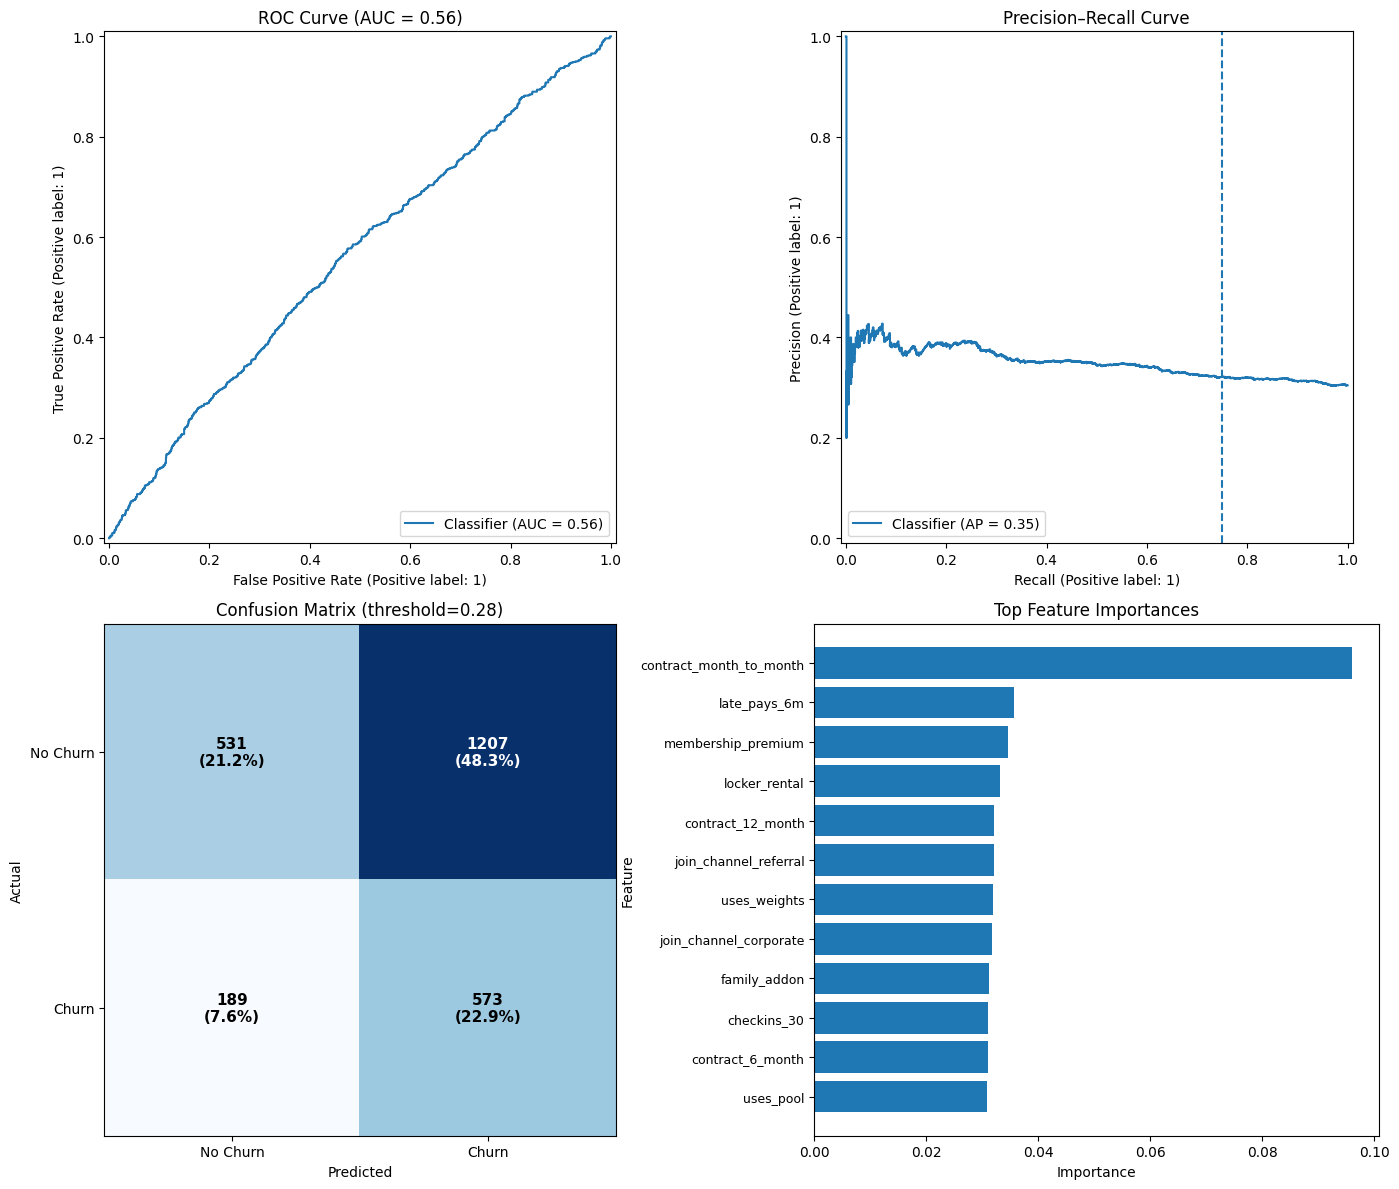


Saved: charts/gym_churn_dashboard.png and gym_membership_dataset.csv


<Figure size 640x480 with 0 Axes>

In [13]:
# Gym Membership Churn Prediction — Option A (Realistic)
# pip install xgboost scikit-learn pandas matplotlib numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve,
    classification_report
)
from sklearn.impute import SimpleImputer

# Try XGBoost; fallback to sklearn
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    USE_XGB = False


# ------------------------------------------------------------------------------
# 1) SYNTHETIC GYM DATASET (10k realistic members)
# ------------------------------------------------------------------------------
rng = np.random.default_rng(2025)
N = 10000

age = rng.integers(16, 80, size=N)
gender = rng.choice(["M","F","Other"], size=N, p=[0.48, 0.50, 0.02])
tenure_m = rng.integers(1, 72, size=N)  # months since join

contract = rng.choice(["month_to_month","6_month","12_month"], size=N, p=[0.55, 0.2, 0.25])
membership = rng.choice(["basic","standard","premium"], size=N, p=[0.45, 0.4, 0.15])
join_channel = rng.choice(["walk_in","online","referral","corporate"], size=N, p=[0.45,0.35,0.1,0.1])

base_price = (
    (membership=="basic")*29
  + (membership=="standard")*49
  + (membership=="premium")*79
).astype(float)

discount = rng.choice([0, 5, 10, 15, 20], size=N, p=[0.55,0.15,0.15,0.1,0.05])
price_paid = np.maximum(15, base_price - discount + rng.normal(0,2,size=N))

# Location / engagement
distance_km = rng.gamma(2.0, 2.0, size=N)  # skewed right
app_logins_30 = rng.poisson(8, size=N)
checkins_30 = np.clip(rng.normal(10, 6, size=N).round().astype(int), 0, 40)
checkins_90 = np.clip(checkins_30 + rng.normal(18, 10, size=N), 0, 120)
classes_90 = np.clip(rng.poisson(6, size=N) + (membership=="premium")*6, 0, None)
pt_sessions_90 = np.clip(rng.poisson(1, size=N) + (membership=="premium")*1 + (membership=="standard")*0.3, 0, None)

# Facilities usage
uses_pool    = rng.choice([0,1], size=N, p=[0.7,0.3])
uses_weights = rng.choice([0,1], size=N, p=[0.2,0.8])
uses_classes = (classes_90 > 0).astype(int)

# Frictions / risks
freezes_12m = rng.poisson(0.2, size=N) + (contract=="month_to_month")*rng.poisson(0.1, size=N)
late_pays_6m = rng.poisson(0.15, size=N)
complaints_6m = rng.poisson(0.1, size=N)

locker_rental = rng.choice([0,1], size=N, p=[0.85,0.15])
referral = (join_channel=="referral").astype(int)
family_addon = rng.choice([0,1], size=N, p=[0.9,0.1])

# Trend features: recent drop in attendance
trend_delta = np.clip(checkins_30 - (checkins_90/3), -20, 20)  # recent vs 3-month avg

# Latent churn risk: domain-driven
risk = (
    + 1.2*(contract=="month_to_month").astype(float)
    + 0.9*(tenure_m < 3)
    + 0.7*(trend_delta < -3)
    + 0.6*(checkins_30 < 4)
    + 0.4*(late_pays_6m > 0)
    + 0.35*(freezes_12m >= 2)
    + 0.3*(complaints_6m > 0)
    + 0.25*(distance_km > 6)
    + 0.2*((price_paid - base_price) > 3)  # paying more than cohort
    - 0.4*(pt_sessions_90 > 0)
    - 0.35*(classes_90 > 3)
    - 0.25*(app_logins_30 > 6)
    - 0.2*(membership=="premium")
    + rng.normal(0, 0.5, size=N)
)

p = 1/(1+np.exp(-risk))
# target churn rate ~ 22–28%
churn = (rng.uniform(0,1,size=N) < p*0.55).astype(int)

df = pd.DataFrame({
    "age":age,
    "gender":gender,
    "tenure_m":tenure_m,
    "contract":contract,
    "membership":membership,
    "join_channel":join_channel,
    "price_paid":price_paid.round(2),
    "discount":discount,
    "distance_km":distance_km.round(2),
    "app_logins_30":app_logins_30,
    "checkins_30":checkins_30,
    "checkins_90":checkins_90.astype(int),
    "classes_90":classes_90.astype(int),
    "pt_sessions_90":pt_sessions_90.astype(int),
    "uses_pool":uses_pool,
    "uses_weights":uses_weights,
    "uses_classes":uses_classes,
    "freezes_12m":freezes_12m,
    "late_pays_6m":late_pays_6m,
    "complaints_6m":complaints_6m,
    "locker_rental":locker_rental,
    "referral":referral,
    "family_addon":family_addon,
    "trend_delta":trend_delta,
    "churn":churn
})

# sprinkle a few missing values like real life
for col in ["price_paid","join_channel","checkins_30"]:
    m = rng.choice([True,False], size=N, p=[0.01,0.99])
    df.loc[m, col] = np.nan


# ------------------------------------------------------------------------------
# 2) SPLIT + PREPROCESS
# ------------------------------------------------------------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])


# ------------------------------------------------------------------------------
# 3) MODEL (class-imbalance aware) + TRAIN
# ------------------------------------------------------------------------------
pos_rate = y_train.mean()
neg_rate = 1 - pos_rate
scale_pos_weight = float(neg_rate / pos_rate)  # ~ cost-sensitive

if USE_XGB:
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.08,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=3,
        gamma=0.0,
        tree_method="hist",
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
else:
    from sklearn.ensemble import HistGradientBoostingClassifier
    model = HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.1, max_iter=400, random_state=42
    )

pipe = Pipeline([("prep", preprocess), ("model", model)])
pipe.fit(X_train, y_train)


# ------------------------------------------------------------------------------
# 4) PREDICT + METRICS (default threshold 0.5)
# ------------------------------------------------------------------------------
if hasattr(model, "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:,1]
else:
    s = pipe.decision_function(X_test)
    y_proba = 1/(1+np.exp(-s))

y_pred_05 = (y_proba >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, y_pred_05)
auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred_05)

print(f"ROC-AUC: {auc:.3f} | Accuracy: {acc:.3f}")
print("\nClassification report (0.5 threshold):\n")
print(classification_report(y_test, y_pred_05))


# ------------------------------------------------------------------------------
# 5) THRESHOLD TUNING (hit a target recall to catch churners)
# ------------------------------------------------------------------------------
prec, rec, th = precision_recall_curve(y_test, y_proba)
target_recall = 0.75  # e.g., catch 75% of churners
# find first threshold achieving at least target_recall
try:
    idx = np.where(rec >= target_recall)[0][-1]
    tuned_thr = th[max(idx-1, 0)]  # th has len-1 vs rec
except Exception:
    tuned_thr = 0.4  # fallback

y_pred_tuned = (y_proba >= tuned_thr).astype(int)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

print(f"\nTuned threshold for recall≥{target_recall:.2f}: {tuned_thr:.3f}")
print("Classification report (tuned):\n")
print(classification_report(y_test, y_pred_tuned))


# ------------------------------------------------------------------------------
# 6) PLOTTING HELPERS
# ------------------------------------------------------------------------------
def plot_confusion_matrix(cm, ax=None, class_names=("No Churn","Churn")):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    # percentages of total
    cm_percent = cm / cm.sum() * 100
    vmin, vmax = im.get_clim()
    thr = (vmin + vmax) / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i,j]
            pct = cm_percent[i,j]
            color = "white" if im.get_array()[i,j] > thr else "black"
            ax.text(j,i,f"{val}\n({pct:.1f}%)",ha="center",va="center",
                    color=color,fontsize=11,fontweight="bold")
    return ax

def get_feature_importances(pipe, cat_cols, num_cols):
    ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols
    model = pipe.named_steps["model"]
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature":feature_names,"importance":importances})
    return fi.sort_values("importance", ascending=False)

# ------------------------------------------------------------------------------
# 7) 2×2 DASHBOARD (ROC, PR, ConfMat @ tuned, Feature Importance)
# ------------------------------------------------------------------------------
fi = get_feature_importances(pipe, cat_cols, num_cols).head(12)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0,0])
axes[0,0].set_title(f"ROC Curve (AUC = {auc:.2f})")

# Precision–Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[0,1])
axes[0,1].axvline(x=target_recall, linestyle="--")
axes[0,1].set_title("Precision–Recall Curve")

# Confusion Matrix at tuned threshold
plot_confusion_matrix(cm_tuned, ax=axes[1,0], class_names=("No Churn","Churn"))
axes[1,0].set_title(f"Confusion Matrix (threshold={tuned_thr:.2f})")

# Feature Importances
axes[1,1].barh(fi["feature"][::-1], fi["importance"][::-1])
axes[1,1].set_title("Top Feature Importances")
axes[1,1].set_xlabel("Importance")
axes[1,1].set_ylabel("Feature")
axes[1,1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

# Optional: save charts
os.makedirs("charts", exist_ok=True)
plt.savefig("charts/gym_churn_dashboard.png", dpi=300)
df.to_csv("gym_membership_dataset.csv", index=False)
print("\nSaved: charts/gym_churn_dashboard.png and gym_membership_dataset.csv")

ROC-AUC: 0.726 | Acc@0.5: 0.728 | Acc@0.21: 0.587

Classification report @ 0.5:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1965
           1       0.39      0.46      0.42       535

    accuracy                           0.73      2500
   macro avg       0.62      0.63      0.62      2500
weighted avg       0.75      0.73      0.74      2500


Tuned threshold to reach recall≈80%: 0.21

Classification report @ tuned:
               precision    recall  f1-score   support

           0       0.91      0.53      0.67      1965
           1       0.32      0.80      0.45       535

    accuracy                           0.59      2500
   macro avg       0.61      0.67      0.56      2500
weighted avg       0.78      0.59      0.62      2500



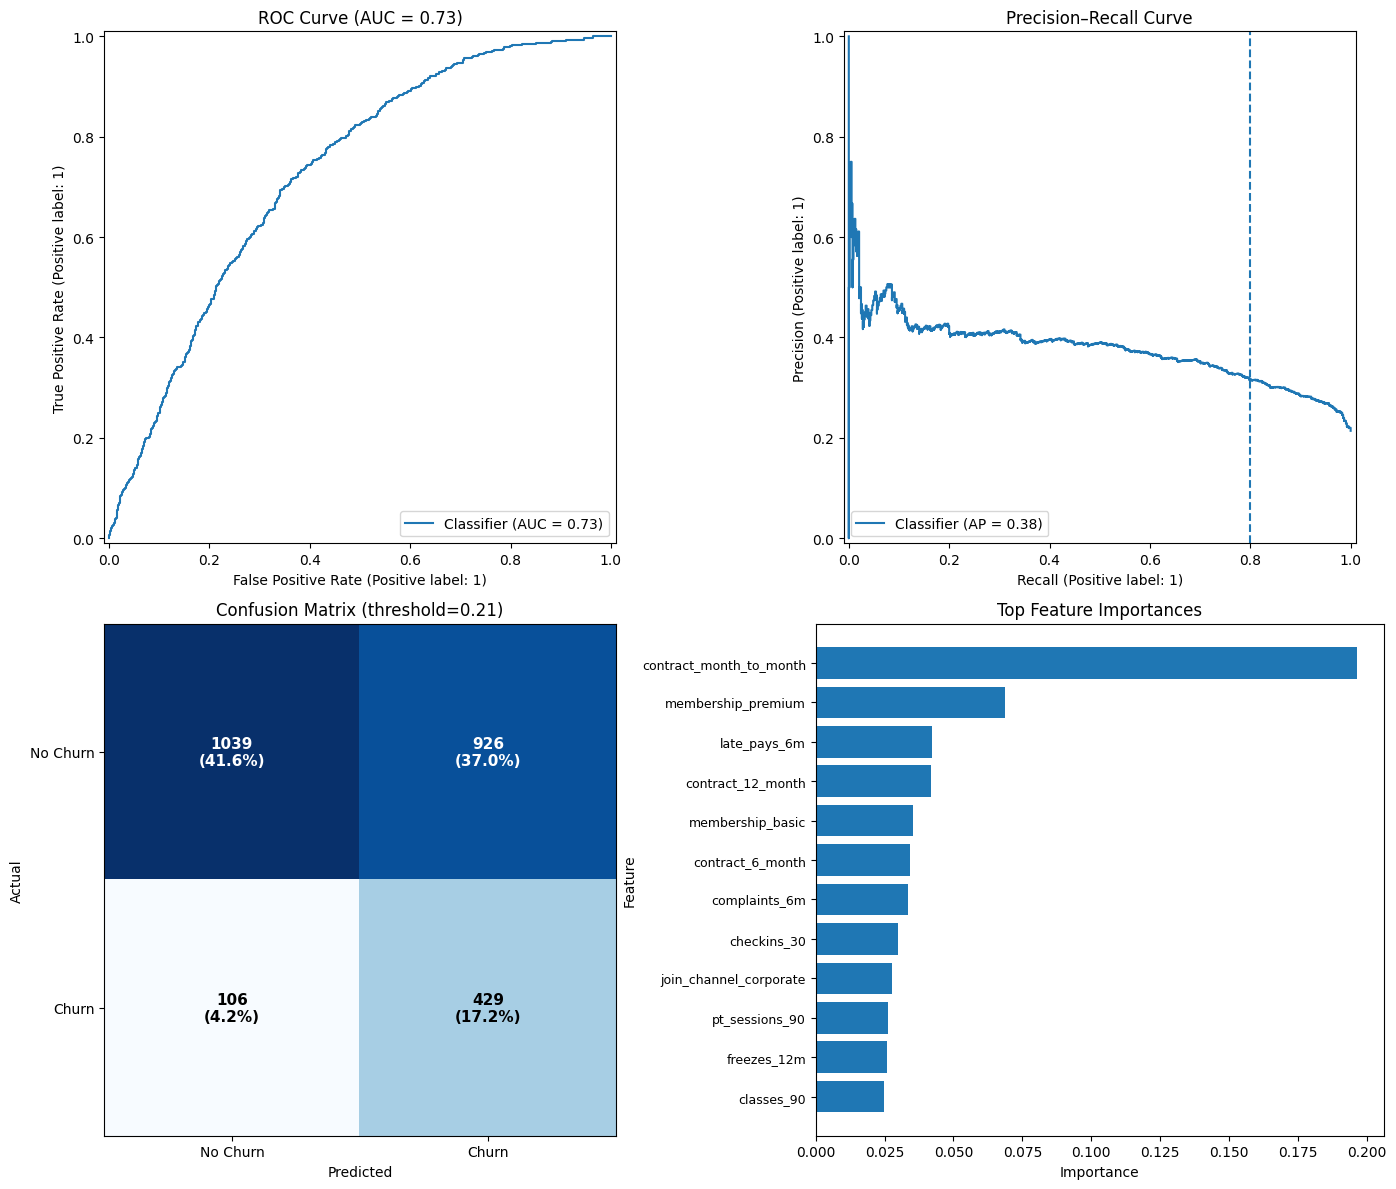


Saved: charts/gym_churn_dashboard.png and gym_membership_dataset.csv


In [1]:
# Gym Membership Churn Prediction — Improved Version
# - Stronger signal in the synthetic data (clear churn drivers)
# - Lower noise so patterns are learnable
# - Class-imbalance handling (scale_pos_weight)
# - Threshold tuning to hit a target recall (catch churners)
# - 2x2 dashboard: ROC, PR, Confusion Matrix, Feature Importances
# - Exports PNG and CSV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve,
    classification_report
)
from sklearn.impute import SimpleImputer

# Try XGBoost; fallback to sklearn boosting
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    USE_XGB = False

# ---------------------------------------------------------------------
# 1) SYNTHETIC GYM DATASET (realistic, with stronger signals)
# ---------------------------------------------------------------------
rng = np.random.default_rng(2025)
N = 10000

age = rng.integers(16, 80, size=N)
gender = rng.choice(["M","F","Other"], size=N, p=[0.48, 0.50, 0.02])
tenure_m = rng.integers(1, 72, size=N)

contract = rng.choice(["month_to_month","6_month","12_month"], size=N, p=[0.55, 0.2, 0.25])
membership = rng.choice(["basic","standard","premium"], size=N, p=[0.45, 0.4, 0.15])
join_channel = rng.choice(["walk_in","online","referral","corporate"], size=N, p=[0.45,0.35,0.1,0.1])

base_price = ((membership=="basic")*29 + (membership=="standard")*49 + (membership=="premium")*79).astype(float)
discount = rng.choice([0,5,10,15,20], size=N, p=[0.55,0.15,0.15,0.1,0.05])
price_paid = np.maximum(15, base_price - discount + rng.normal(0,2,size=N))

distance_km = rng.gamma(2.0, 2.0, size=N)  # skewed right
app_logins_30 = rng.poisson(8, size=N)
checkins_30 = np.clip(rng.normal(10, 6, size=N).round().astype(int), 0, 40)
checkins_90 = np.clip(checkins_30 + rng.normal(18, 10, size=N), 0, 120)
classes_90 = np.clip(rng.poisson(6, size=N) + (membership=="premium")*6, 0, None)
pt_sessions_90 = np.clip(rng.poisson(1, size=N) + (membership=="premium")*1 + (membership=="standard")*0.3, 0, None)

uses_pool    = rng.choice([0,1], size=N, p=[0.7,0.3])
uses_weights = rng.choice([0,1], size=N, p=[0.2,0.8])
uses_classes = (classes_90 > 0).astype(int)

freezes_12m = rng.poisson(0.2, size=N) + (contract=="month_to_month")*rng.poisson(0.1, size=N)
late_pays_6m = rng.poisson(0.15, size=N)
complaints_6m = rng.poisson(0.1, size=N)

locker_rental = rng.choice([0,1], size=N, p=[0.85,0.15])
referral = (join_channel=="referral").astype(int)
family_addon = rng.choice([0,1], size=N, p=[0.9,0.1])

trend_delta = np.clip(checkins_30 - (checkins_90/3), -20, 20)  # recent minus 3-month avg

# >>> Stronger, clearer churn signals; reduced noise <<<
risk = (
    + 2.8*(contract=="month_to_month").astype(float)
    + 2.2*(tenure_m < 3)
    + 1.9*(trend_delta < -4)
    + 1.7*(checkins_30 < 3)
    + 1.4*(late_pays_6m > 0)
    + 1.2*(freezes_12m >= 2)
    + 1.0*(complaints_6m > 0)
    + 0.9*(distance_km > 7)

    - 1.6*(pt_sessions_90 > 0)
    - 1.3*(classes_90 > 3)
    - 1.0*(app_logins_30 > 8)
    - 1.4*(membership=="premium")

    + rng.normal(0, 0.2, size=N)  # lower noise
)

p = 1/(1+np.exp(-risk))
churn = (rng.uniform(0,1,size=N) < p*0.5).astype(int)  # ~20–30% churn

df = pd.DataFrame({
    "age":age, "gender":gender, "tenure_m":tenure_m,
    "contract":contract, "membership":membership, "join_channel":join_channel,
    "price_paid":price_paid.round(2), "discount":discount,
    "distance_km":distance_km.round(2),
    "app_logins_30":app_logins_30, "checkins_30":checkins_30, "checkins_90":checkins_90.astype(int),
    "classes_90":classes_90.astype(int), "pt_sessions_90":pt_sessions_90.astype(int),
    "uses_pool":uses_pool, "uses_weights":uses_weights, "uses_classes":uses_classes,
    "freezes_12m":freezes_12m, "late_pays_6m":late_pays_6m, "complaints_6m":complaints_6m,
    "locker_rental":locker_rental, "referral":referral, "family_addon":family_addon,
    "trend_delta":trend_delta, "churn":churn
})

# sprinkle realistic missing values
for col in ["price_paid","join_channel","checkins_30"]:
    m = rng.choice([True,False], size=N, p=[0.01,0.99])
    df.loc[m, col] = np.nan

# ---------------------------------------------------------------------
# 2) SPLIT + PREPROCESS
# ---------------------------------------------------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

# ---------------------------------------------------------------------
# 3) MODEL (imbalance aware) + TRAIN
# ---------------------------------------------------------------------
pos_rate = y_train.mean()
neg_rate = 1 - pos_rate
scale_pos_weight = float(neg_rate / pos_rate)

if USE_XGB:
    model = XGBClassifier(
        n_estimators=600, learning_rate=0.08, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        min_child_weight=3, gamma=0.0, tree_method="hist",
        eval_metric="logloss", random_state=42,
        scale_pos_weight=scale_pos_weight
    )
else:
    from sklearn.ensemble import HistGradientBoostingClassifier
    model = HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.1, max_iter=450, random_state=42
    )

pipe = Pipeline([("prep", preprocess), ("model", model)])
pipe.fit(X_train, y_train)

# ---------------------------------------------------------------------
# 4) METRICS + THRESHOLD TUNING
# ---------------------------------------------------------------------
if hasattr(model, "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:,1]
else:
    s = pipe.decision_function(X_test)
    y_proba = 1/(1+np.exp(-s))

# Default 0.5
y_pred_05 = (y_proba >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, y_pred_05)
auc = roc_auc_score(y_test, y_proba)
acc_05 = accuracy_score(y_test, y_pred_05)

# Tune threshold to hit recall target (catch more churners)
prec, rec, th = precision_recall_curve(y_test, y_proba)
target_recall = 0.80
try:
    idx = np.where(rec >= target_recall)[0][-1]
    tuned_thr = th[max(idx-1, 0)]
except Exception:
    tuned_thr = 0.4  # safe fallback

y_pred_tuned = (y_proba >= tuned_thr).astype(int)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
acc_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"ROC-AUC: {auc:.3f} | Acc@0.5: {acc_05:.3f} | Acc@{tuned_thr:.2f}: {acc_tuned:.3f}")
print("\nClassification report @ 0.5:\n", classification_report(y_test, y_pred_05))
print(f"\nTuned threshold to reach recall≈{target_recall:.0%}: {tuned_thr:.2f}")
print("\nClassification report @ tuned:\n", classification_report(y_test, y_pred_tuned))

# ---------------------------------------------------------------------
# 5) PLOTTING HELPERS
# ---------------------------------------------------------------------
def plot_confusion_matrix(cm, ax=None, class_names=("No Churn","Churn")):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    cm_percent = cm / cm.sum() * 100
    vmin, vmax = im.get_clim()
    thr = (vmin + vmax) / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i,j]; pct = cm_percent[i,j]
            color = "white" if im.get_array()[i,j] > thr else "black"
            ax.text(j,i,f"{val}\n({pct:.1f}%)",ha="center",va="center",
                    color=color,fontsize=11,fontweight="bold")
    return ax

def get_feature_importances(pipe, cat_cols, num_cols):
    ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols
    model = pipe.named_steps["model"]
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature":feature_names,"importance":importances})
    return fi.sort_values("importance", ascending=False)

# ---------------------------------------------------------------------
# 6) 2×2 DASHBOARD (ROC, PR, ConfMat @ tuned, Feature Importances)
# ---------------------------------------------------------------------
fi = get_feature_importances(pipe, cat_cols, num_cols).head(12)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0,0])
axes[0,0].set_title(f"ROC Curve (AUC = {auc:.2f})")

# Precision–Recall (+ vertical line at target recall)
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[0,1])
axes[0,1].axvline(x=target_recall, linestyle="--")
axes[0,1].set_title("Precision–Recall Curve")

# Confusion Matrix at tuned threshold
plot_confusion_matrix(cm_tuned, ax=axes[1,0], class_names=("No Churn","Churn"))
axes[1,0].set_title(f"Confusion Matrix (threshold={tuned_thr:.2f})")

# Feature Importances
axes[1,1].barh(fi["feature"][::-1], fi["importance"][::-1])
axes[1,1].set_title("Top Feature Importances")
axes[1,1].set_xlabel("Importance")
axes[1,1].set_ylabel("Feature")
axes[1,1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
os.makedirs("charts", exist_ok=True)
plt.savefig("charts/gym_churn_dashboard.png", dpi=300)
plt.show()

# ---------------------------------------------------------------------
# 7) SAVE DATASET
# ---------------------------------------------------------------------
df.to_csv("gym_membership_dataset.csv", index=False)
print("\nSaved: charts/gym_churn_dashboard.png and gym_membership_dataset.csv")